# Data Mining in Action 2016 (осенний семестр)

## Задача на семинар: цветовая сегментация кожи на изображении

В этом примере мы построим простой классификатор с использованием библиотеки scikit-learn. В качестве данных мы возьмем выборку из UCI Репозитория (www.archive.ics.uci.edu), связанную с задачей сегментации изображений, а точнее - выделением кожи на фотографиях. 

В итоге мы получим классификатор, который по RBG представлению цвета пикселя будет пытаться определить, принадлежит пиксель к участку кожи или нет.

<img src="skin_segmentation2.png" />

Для начала скачаем выборку по следующей ссылке: https://archive.ics.uci.edu/ml/machine-learning-databases/00229/Skin_NonSkin.txt

In [1]:
!curl https://archive.ics.uci.edu/ml/machine-learning-databases/00229/Skin_NonSkin.txt > Skin_NonSkin.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 3321k  100 3321k    0     0   117k      0  0:00:28  0:00:28 --:--:-- 92164


## Задаем кодировку

В Python кодировка файла скрипта задается с помощью так называемого magic comment: # coding: utf-8
(либо другая кодировка по необходимости).

Волшебный комментарий должен быть в первых двух строчках скрипта, иначе он игнорируется интерпретатором. Добавив этот комментарий в скрипт можно, например, комфортно использовать в коде русскоязычные строки и комментарии. Однако для ipython notebook такой способ не подходит ведь разные блоки кода могут исполняться в разной последовательности. Есть другой способ, им и воспользуемся:

In [2]:
import sys
reload(sys)
sys.setdefaultencoding("utf-8")

После исполнения этого блока проблем с русскоязычными комментариями в коде быть не должно.

## Чтение выборки

Давайте посмотрим на выборку и попробуем понять, какой смысл имеют

In [1]:
dataset_path = "Skin_NonSkin.txt"
dataset_file = open(dataset_path, 'r')
dataset_text = dataset_file.read().split('\n')


In [2]:
dataset = [map(int, line.split('\t')) for line in dataset_text if len(line) > 0]
print dataset[:10]

[[74, 85, 123, 1], [73, 84, 122, 1], [72, 83, 121, 1], [70, 81, 119, 1], [70, 81, 119, 1], [69, 80, 118, 1], [70, 81, 119, 1], [70, 81, 119, 1], [76, 87, 125, 1], [76, 87, 125, 1]]


In [3]:
X = [line[:-1] for line in dataset]
y = [line[-1] for line in dataset]

print X[:5]

#print "123",

print y[:5]

[[74, 85, 123], [73, 84, 122], [72, 83, 121], [70, 81, 119], [70, 81, 119]]
[1, 1, 1, 1, 1]


### Оказывается все в bgr, а не rgb

In [22]:
X[:, [0, 2]] = X[:, [2, 0]]

In [23]:
import numpy as np

np.random.seed(0)
indices = np.random.permutation(len(X))
X = np.array(X)
y = np.array(y)
test_size = 100000
X_train = X[indices[:-test_size]]
y_train = y[indices[:-test_size]]
X_test  = X[indices[-test_size:]]
y_test  = y[indices[-test_size:]]


In [24]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier()
model.fit(X_train, y_train)


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [25]:
predicted = model.predict(X_test)
print predicted[:10]

[2 2 1 1 2 1 2 2 1 2]


In [26]:
print float(sum(y_test == predicted))/test_size

0.99949


## Чтение и обработка изображения

Для работы с графиками и изображениями в Python есть библиотека Matplotlib. На сайте библиотеки www.matplotlib.org описан API и есть большое количество примеров в разделе gallery. При необходимости построить график можно зайти в галерею, найти визуально картинку, наиболее похожую на нужную и посмотреть код.

Но сейчас мы воспользуемся matplotlib для работы с изображением, на котором хотим найти участки кожи. Для начала считаем изображение:

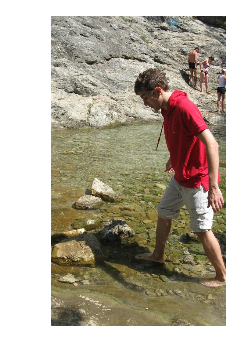

In [27]:
%matplotlib inline 
# чтобы изображения выводились прямо в ipython notebook, а не в отдельном окне


import matplotlib.pyplot as plt
import matplotlib.cbook as cbook

image_path = "kantor.jpg"

image_file = open(image_path, 'rb')
#image_file = cbook.get_sample_data(image_path)
image = plt.imread(image_file)

plt.imshow(image)
plt.axis('off') # clear x- and y-axes
plt.show()

Посмотрим, в каком формате хранится изображение в переменой image:

In [28]:
print type(image)

<type 'numpy.ndarray'>


Поскольку это массив, попробуем вывести несколько его первых элементов:

In [36]:
print image[1, 1]

[146 135 131]


Похоже на массив строк пикселей. Каждая строка - массив пикселей, а пиксель - массив из трех чисел - RGB представления цвета пикселя.

Обучим наш классификатор на всей обучающей выборке и прогоним классификатор по всем пикселям изображения, заменяя пиксели кожи на ярко зелёные:

In [30]:
model.fit(X, y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [31]:
for i, line in enumerate(image):
    classes = model.predict(line) # predict принимает список объектов
    for j, ans in enumerate(classes):
        if ans == 1:
            image[i, j, 0] = image[i, j, 2] = 0
            image[i, j, 1] = 255

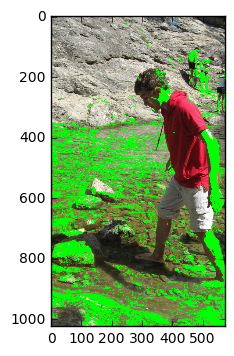

In [32]:
plt.imshow(image)
plt.show()

Не правда ли, какой-то подозрительный результат?

### Распределение цветов на изображении

(array([   365.,    845.,   5779.,   8814.,  10690.,   9354.,  13754.,
         17916.,  20622.,  18396.,  20674.,  17270.,  21884.,  25700.,
         40965.,  45870.,  49838.,  40090.,  39881.,  30269.,  28016.,
         20036.,  18545.,  14811.,  15318.,  12430.,  12160.,   8480.,
          7442.,  11562.]),
 array([   0. ,    8.5,   17. ,   25.5,   34. ,   42.5,   51. ,   59.5,
          68. ,   76.5,   85. ,   93.5,  102. ,  110.5,  119. ,  127.5,
         136. ,  144.5,  153. ,  161.5,  170. ,  178.5,  187. ,  195.5,
         204. ,  212.5,  221. ,  229.5,  238. ,  246.5,  255. ]),
 <a list of 30 Patch objects>)

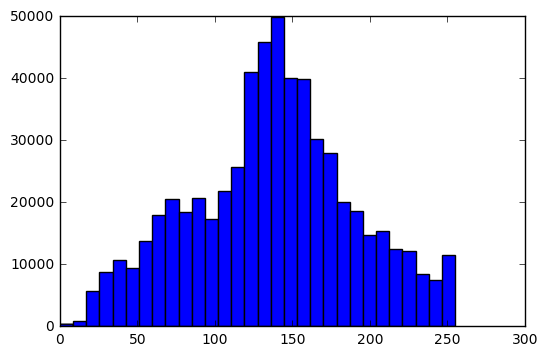

In [16]:
plt.hist(image[:, :, 0].flatten(), bins=30)

(array([  1745.,  12969.,  15681.,  12425.,  15973.,  16682.,  18267.,
         15001.,  16280.,  15414.,  19949.,  20058.,  29525.,  35796.,
         48715.,  38874.,  40288.,  33357.,  33022.,  26098.,  25420.,
         18883.,  17681.,  14109.,  14903.,  10924.,   8934.,   4974.,
          2965.,   2864.]),
 array([   0. ,    8.5,   17. ,   25.5,   34. ,   42.5,   51. ,   59.5,
          68. ,   76.5,   85. ,   93.5,  102. ,  110.5,  119. ,  127.5,
         136. ,  144.5,  153. ,  161.5,  170. ,  178.5,  187. ,  195.5,
         204. ,  212.5,  221. ,  229.5,  238. ,  246.5,  255. ]),
 <a list of 30 Patch objects>)

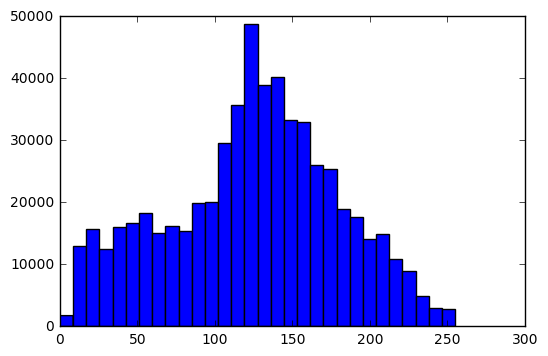

In [17]:
plt.hist(image[:, :, 1].flatten(), bins=30)

(array([  2050.,  16035.,  29612.,  22955.,  27414.,  23617.,  29512.,
         28596.,  35331.,  37590.,  41716.,  32715.,  32524.,  25401.,
         27062.,  22509.,  23224.,  18480.,  19552.,  15916.,  16443.,
         13731.,  14283.,  10483.,   8861.,   5007.,   2960.,   1373.,
          1186.,   1638.]),
 array([   0. ,    8.5,   17. ,   25.5,   34. ,   42.5,   51. ,   59.5,
          68. ,   76.5,   85. ,   93.5,  102. ,  110.5,  119. ,  127.5,
         136. ,  144.5,  153. ,  161.5,  170. ,  178.5,  187. ,  195.5,
         204. ,  212.5,  221. ,  229.5,  238. ,  246.5,  255. ]),
 <a list of 30 Patch objects>)

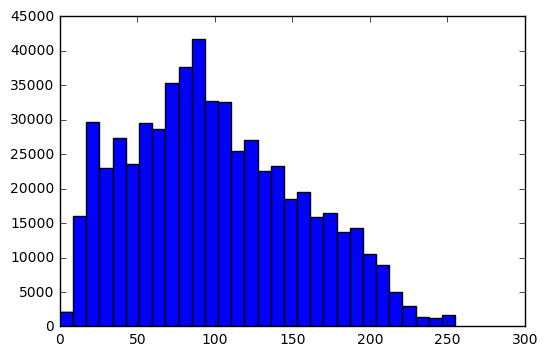

In [18]:
plt.hist(image[:, :, 2].flatten(), bins=30)

### Распределение цветов в выборке

(array([  9885.,   5093.,   4653.,   3734.,   5608.,   6418.,  16284.,
          8810.,   6944.,   6168.,   5890.,   6697.,   6910.,   6809.,
          7960.,   9272.,  12370.,  10146.,  12367.,  15885.,  24386.,
         19533.,   6971.,  15646.,   2717.,    591.,   1367.,   1472.,
          1446.,   3025.]),
 array([   0. ,    8.5,   17. ,   25.5,   34. ,   42.5,   51. ,   59.5,
          68. ,   76.5,   85. ,   93.5,  102. ,  110.5,  119. ,  127.5,
         136. ,  144.5,  153. ,  161.5,  170. ,  178.5,  187. ,  195.5,
         204. ,  212.5,  221. ,  229.5,  238. ,  246.5,  255. ]),
 <a list of 30 Patch objects>)

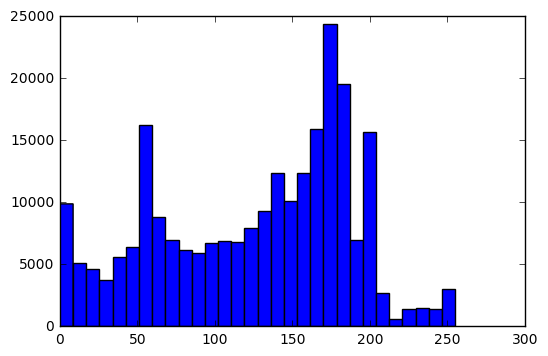

In [19]:
plt.hist(X[:, 0], bins=30)

(array([  8980.,   5158.,   3916.,   3680.,   4270.,   3366.,  11534.,
          6803.,   6577.,   5470.,   7700.,   5574.,   6011.,   5322.,
          6185.,   7821.,  13783.,   9620.,  15504.,  21225.,  31285.,
         18054.,  13422.,  13683.,   3177.,   1690.,   1207.,    630.,
           598.,   2812.]),
 array([   0. ,    8.5,   17. ,   25.5,   34. ,   42.5,   51. ,   59.5,
          68. ,   76.5,   85. ,   93.5,  102. ,  110.5,  119. ,  127.5,
         136. ,  144.5,  153. ,  161.5,  170. ,  178.5,  187. ,  195.5,
         204. ,  212.5,  221. ,  229.5,  238. ,  246.5,  255. ]),
 <a list of 30 Patch objects>)

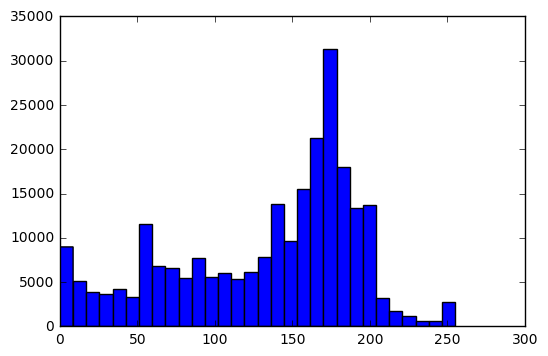

In [20]:
plt.hist(X[:, 1], bins=30)

(array([ 17451.,   5806.,  16178.,   6702.,   4737.,   2970.,   3741.,
          2839.,   2598.,   3168.,  10007.,   6197.,   5778.,  12870.,
         21042.,  24790.,  10496.,   6906.,  11815.,  10899.,   3909.,
          3031.,   4033.,   2632.,   4233.,   8016.,  10665.,   6723.,
          3513.,  11312.]),
 array([   0. ,    8.5,   17. ,   25.5,   34. ,   42.5,   51. ,   59.5,
          68. ,   76.5,   85. ,   93.5,  102. ,  110.5,  119. ,  127.5,
         136. ,  144.5,  153. ,  161.5,  170. ,  178.5,  187. ,  195.5,
         204. ,  212.5,  221. ,  229.5,  238. ,  246.5,  255. ]),
 <a list of 30 Patch objects>)

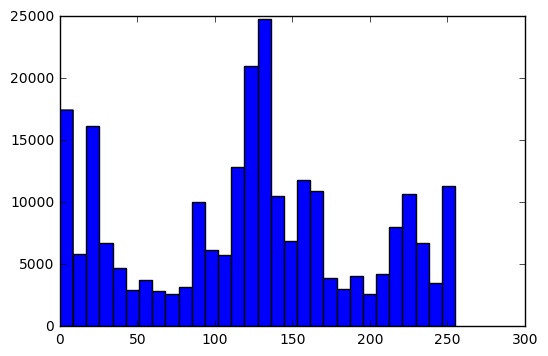

In [21]:
plt.hist(X[:, 2], bins=30)

## Задание

#### На семинаре:

1. Выяснить, почему на изображении не выделились участки кожи и исправить ситуацию. Подсказка: читайте документацию библиотек либо пробуйте визуализировать цвета, которые классификатор относит к коже. Блокнот с решением проблемы выложить на github.
1. Сравнить качество на отложенной выборке при разном количестве соседей k в kNN (от 1 до 10) и при разных весах во взвешенной версии kNN (см. документацию scikit-learn). 
1. Блокнот с исправлением детектирования кожи и экспериментами выслать на datamininginaction@gmail.com

#### Дополнительные задания (к следующему занятию):

1. С помощью matplotlib построить трёхмерную визуализацию выборки и выслать на тот же адрес.
1. Разобрать презенташку про numpy, scipy, matplotlib: http://mit.spbau.ru/files/scipy.pdf
1. Разобрать Crash Course in Python for scientists.